<h1> Binomial Option Pricing Model </h1>
<h4> Author: Jakob Lindstrøm </h4>
<br>
<p> This program was written in the context of answering a mandatory exercise in the course Project Evaluation and Finance. The model takes in the basic input from the user. Based on the input the  program can visualize the binommial tree, with asset value and the corrsponding option price. 

<h2> 1. Input from user </h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# # Input cell, stating input
# print('State some information about the underlying asset and the option specifics:')
# spot_0 = float(input('\nSpotprice at time 0: '))
# strike = float(input('Strike price: '))

# sig = float(input('\nYearly sigma: '))
# h = float(input('Time interval (months): '))
# periods = float(input('Number of periods (months): '))

# rate_i = float(input('\nInterest rate: '))
# rate_dy = float(input('Dividend yield: '))

# option_type = str(input('\n"Call" or "Put" option? '))
# exercise_style = str(input('\n"American" or "European" style? '))

In [2]:
spot_0 = 1.05
strike = 1.10
sig=0.1

h=2
periods=6

rate_i=0.055
rate_dy=0.031

option_type='Put'
exercise_style='American'

<h2> 2. Functions </h2>
<br>
I have created five functions. 
<ol>
    <li> The first function find the up- and downside value of the asset for one period.</li>
    <li> The second function finds the value for the asset given all periods and all thinkable up- and downsides moves the asset can take.</li>
    <li> The third function calculate the price of a single value.</li>
    <li> The fourth functions collect all the prices for all the option values that's been calculated using the second funciton.</li>
    <li> The fifth and last function plots "a tree" to give a good visualization to see the value and price of the options.</li>
</ol>

In [4]:
# Function for up- and downside  valuechange in the asset
# Shall not be called externally
def up_and_down(spot, h):
    h =  h/12
    
    uS = spot*np.e**((rate_i -rate_dy) * h + sig*np.sqrt(h)) 
    dS = spot*np.e**((rate_i -rate_dy) * h - sig*np.sqrt(h))
    
    return [uS, dS]

    
# Function for creating the binomial tree with
# values for all periods
# Should be called externally
def bin_tree_value(spot_0, sig, h, periods,
                  rate_i, rate_dy):

    numb_periods =  int(periods/h)

    storage = [[spot_0]]
    for i in range(0, numb_periods,1):
        sub_storage = []
        for j in range(0, len(storage[i]),2):   
            sub_storage.append(np.array(up_and_down(storage[i][j],h)))
        if (i+1)>=2:
            if (i+1)%2== 0:
                sub_storage.append(np.reshape(up_and_down(storage[i][j+1],h)[1],(1,)))
        fixed = np.concatenate(sub_storage)
        storage.append(np.round(fixed,3))
    return storage


# Function for calculating the value of single option
# Shall not be called externally
def option_price(up,down, 
                 spot,strike,
                 rate_i, rate_dy, 
                 h, high_optpri, low_optpri,
                 option_type='',
                 exercise_style=''):
    h = h/12
    u = up/spot
    d = down/spot  
    p = (np.e**((rate_i-rate_dy)*h)-d)/(u-d)

    opt_price = np.e**(-rate_i*h) *((high_optpri*p)+(low_optpri*(1-p)))
    if exercise_style == 'European':
        opt_price = opt_price
    elif exercise_style == 'American':
        if option_type=='Put':
            opt_price = max(opt_price, strike-spot)
        else:
            opt_price = max(opt_price, spot-strike)            
    else:
        print('State exercise style!!!')
    return round(opt_price,3)

# Function for generating the tree of option values
# Needs to be called externally
def bin_tree_optprice(strike, h,periods, storage, 
                      option_type='', exercise_style=''):
    numb_periods = int(periods/h)
    latest_opt_pri = []
    
    if option_type=='Call':
        array = np.where(storage[numb_periods]-strike>0,storage[numb_periods]-strike,0)
    elif option_type=='Put':
        array = np.where(storage[numb_periods]-strike<0,storage[numb_periods]-strike,0)
    else:
        print('State option type!!!')
    latest_opt_pri.append(abs(array))

    for i in range(0, numb_periods, 1): #periods -1
        sub_optpri_storage = []
        for j in range(0,numb_periods-i,1):   #periods- 1
            sub_optpri_storage.append(option_price(storage[numb_periods][-j-1], 
                                                    storage[numb_periods][-j-2],
                                                    storage[numb_periods-1][-j-1], 
                                                   strike,
                                                    rate_i, rate_dy, h,
                                                    latest_opt_pri[i][-1-j], 
                                                   latest_opt_pri[i][-2-j],
                                                   option_type=option_type,
                                                  exercise_style=exercise_style))
        latest_opt_pri.append(np.flip(np.round(sub_optpri_storage,2)))
    return np.flip(latest_opt_pri)


# Function for plotting the binomial tree
# Should be called externally
def plot_bin_tree(storage, prices, periods, txt_shift):
    fig, ax = plt.subplots(figsize=(6,6))
#     ax.scatter(x=[0], y=[storage[0][0]])
    for i in range(0,int(periods/h)+1,1):
        ax.scatter(x=np.repeat((i)*h,i+1), y= storage[i])
        for j in range(0,i+1,1):
            text_value = 'Value '+ str(storage[i][j])
            text_price = 'Price '+ str(prices[i][j])
            ax.annotate(text_value, xy=(i*h, storage[i][j]+txt_shift))
            ax.annotate(text_price, xy=(i*h, storage[i][j]-txt_shift))
        ax.set_xlabel('Months')
    ax.set_ylabel('Price')
    plt.xlim(-2,periods+2*h)
    plt.title('Binomial tree for '+exercise_style+' '+option_type+' option')
    plt.show()

<h2>  3. Output

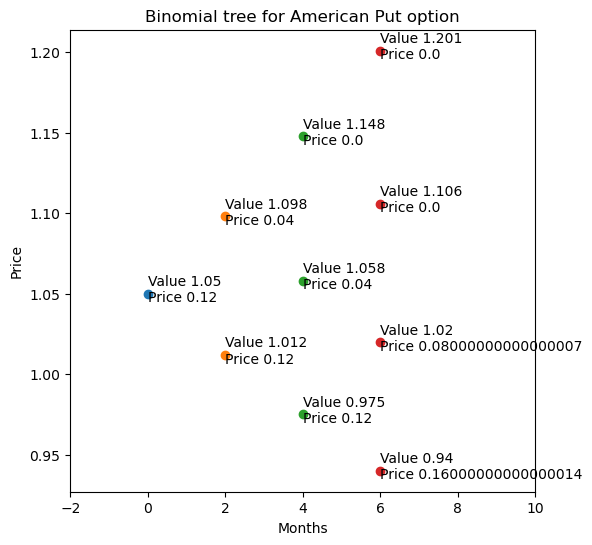

In [5]:
storage = bin_tree_value(spot_0, sig, h, periods, rate_i,  rate_dy)

prices = bin_tree_optprice(strike,h, periods, storage,
                           option_type=option_type,
                           exercise_style=exercise_style)
plot_bin_tree(storage, prices, periods, 0.005)

<h2>  4.  Conclusion </h2>
It seems like the program is able to correctly calculate the price of an option. No matter if its a call or put, or if the style of exercise is European or American.